<a href="https://colab.research.google.com/github/aneeshcheriank/approaching-any-machine-learning-problem/blob/main/First_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Conv2DTranspose, Reshape, Dropout

from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [6]:
BUFFER = 1024
BATCH = 256
EPOCHS = 10

In [7]:
# data loader
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = ((x_train-127.5)/127.5).reshape((-1, 28, 28, 1)) # resize the image b/w [-1 and 1]

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))\
.shuffle(BUFFER)\
.batch(BATCH)

x, y = iter(train_data).next()
print(x.shape)
print(y.shape)

11501568/11490434 [==============================] - 0s 0us/step
(256, 28, 28, 1)
(256,)


In [17]:
# models
generator = tf.keras.Sequential([
     Dense(7*7*256, use_bias=False, input_shape=(100, )),
     BatchNormalization(),
     LeakyReLU(),

     Reshape((7, 7, 256)),

     Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
     BatchNormalization(),
     LeakyReLU(),
     # output size (None, 7, 7, 128)

     Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
     BatchNormalization(),
     LeakyReLU(),
     # output size (None, 14, 14, 64)

     Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])
     
#      Sequential([
#         Dense(16, kernel_initializer='he_normal', use_bias = False, input_dim=(100)), 
#         Reshape((4, 4, 1)),               
#         Conv2DTranspose(8, (2, 2), strides=(2, 2), kernel_initializer='he_normal'),  
#         BatchNormalization(),
#         LeakyReLU(alpha=0.5),
#         Conv2DTranspose(8, (2, 2), strides=(2, 2), kernel_initializer='he_normal'),  
#         BatchNormalization(),
#         LeakyReLU(alpha=0.5),
#         Conv2DTranspose(8, (2, 2), strides=(2, 2), kernel_initializer='he_normal'),  
#         BatchNormalization(),
#         LeakyReLU(alpha=0.5),
#         Conv2D(1, (5, 5), activation='tanh')            
# ])

discriminator = tf.keras.Sequential([
      Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
      LeakyReLU(),
      Dropout(0.3),

      Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
      LeakyReLU(),
      Dropout(0.3),

      Flatten(),
      Dense(1, activation='sigmoid')
])

gan = Sequential([
       generator, discriminator           
])

In [ ]:
opt_des = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
opt_gan = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
loss = tf.keras.losses.BinaryCrossentropy()

gan_loss = []
dis_loss = []
# training loop
for epoch in range(EPOCHS):
  d_loss = 0
  g_loss = 0
  start = time.time()
  for real_image, _ in tqdm(train_data):
    batch_size = real_image.shape[0]
    noise = tf.random.normal((batch_size, 100))

    fake_images = tf.cast(generator(noise), dtype=tf.float64)
    train_batch = tf.concat([real_image, fake_images], axis=0)
    labels = tf.concat(
        [[[0.]]*batch_size + [[1.]]*batch_size], axis=0
    )

    # set the discirminator as trainable
    discriminator.trainable = True

    # calculate gradients and update weights
    with tf.GradientTape() as t_des:
      # predict the labels
      pred = discriminator(train_batch)
      l = loss(labels, pred)

    gradients = t_des.gradient(l, discriminator.trainable_weights) 
    opt_des.apply_gradients(
          zip(gradients, discriminator.trainable_weights)
    )
    
    # RMS of the loss
    d_loss += tf.math.reduce_mean(l)

    # set the discirminator as not trainable
    discriminator.trainable = False

    noise = tf.random.normal((batch_size*2, 100))
    labels = tf.constant([[0.]]*(2*batch_size), dtype=tf.float32)

    with tf.GradientTape() as t_gan:
      pred = gan(noise)
      l = loss(labels, pred)

    gradients = t_gan.gradient(l, gan.trainable_weights) 
    opt_gan.apply_gradients(
          zip(gradients, gan.trainable_weights)
    )

    g_loss += tf.math.reduce_mean(l)
  
  gan_loss.append(g_loss.numpy())
  dis_loss.append(d_loss.numpy())
  if (epoch+1)%2 == 0:
    print(f'Epoch {epoch+1}/{EPOCHS}, dis loss {d_loss.numpy():.4f}, gan loss = {g_loss.numpy():.4f}, time to train {(time.time()-start):.4f} sec')
    imgs = generator(tf.random.normal((16, 100)))

    for i, img in enumerate(imgs):
      plt.subplot(4, 4, i+1)
      plt.imshow(((np.squeeze(img)*127.5)+127.5), cmap='gray')
      plt.axis('off')  
    plt.show();

print('discirminator_loss')
print(dis_loss)
print('gan_loss')
print(gan_loss)

100%|██████████| 235/235 [00:47<00:00,  5.39it/s]

- what is the impact of @tf.function
- logits=True, in optimizer
  - to replace sigmoid/softmax activation?
- performance comparison b/w pytorch
- kaggle competition
- change the generator architecture
  - increase the noise size

## Points to note
1. the image should be b/w [-1, 1] (as normal distribtuioin follows this)
2. 2 optimizers for generator and optimizer
3. 2 gradients tapes for generator and the optimizer
4. gradient calculation should be outside the gradientTape

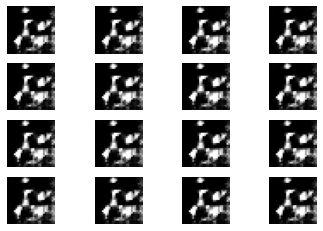

In [13]:
noise = tf.random.normal([16, 100, 1])
images = generator(noise)

for i, img in enumerate(images):
  plt.subplot(4, 4, i+1)
  plt.imshow(np.squeeze(img), cmap='gray')
  plt.axis('off')
plt.show()
